In [20]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib

import sklearn.pipeline
import sklearn.compose
import sklearn.preprocessing
import sklearn.feature_extraction.text

In [21]:
! ls ../data

models  titanic


In [22]:
! ls ../data/titanic

gender_submission.csv test.csv              train.csv


In [50]:
df = pd.read_csv("../data/titanic/train.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Preprocess

array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

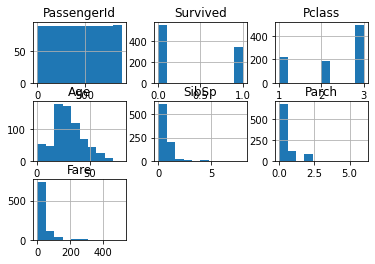

In [21]:
df.hist()

In [51]:
df.loc[df['Cabin'].isnull(), 'Cabin'] = 'None'

In [69]:
preprocessor = sklearn.compose.ColumnTransformer(
    transformers=[
        ('Pclass',   sklearn.preprocessing.FunctionTransformer(), ["Pclass"]), # identity
        ('Sex',      sklearn.preprocessing.OneHotEncoder(), ["Sex"]),
        ('Age',      sklearn.preprocessing.MinMaxScaler(), ["Age"]),
        ('SibSp',    sklearn.preprocessing.QuantileTransformer(), ["SibSp"]),
        ('Parch',    sklearn.preprocessing.FunctionTransformer(), ["Parch"]),
        ('Fare',     sklearn.preprocessing.Normalizer(), ["Fare"]),
        ('Cabin',    sklearn.preprocessing.OrdinalEncoder(), ["Cabin"]),
        ('Embarked', sklearn.preprocessing.OneHotEncoder(), ['Embarked']),
    ],
)
tr = preprocessor.fit(df)

/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2609: UserWarning: n_quantiles (1000) is greater than the total number of samples (891). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


In [73]:
preprocessed_df = tr.transform(df)
preprocessed_df[:10]

array([[3.00000000e+00, 0.00000000e+00, 1.00000000e+00, 2.71173662e-01,
        8.00561798e-01, 0.00000000e+00, 1.00000000e+00, 1.46000000e+02,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 4.72229203e-01,
        8.00561798e-01, 0.00000000e+00, 1.00000000e+00, 8.10000000e+01,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.00000000e+00, 1.00000000e+00, 0.00000000e+00, 3.21437547e-01,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.46000000e+02,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 4.34531289e-01,
        8.00561798e-01, 0.00000000e+00, 1.00000000e+00, 5.50000000e+01,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [3.00000000e+00, 0.00000000e+00, 1.00000000e+00, 4.34531289e-01,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.46

In [74]:
preprocessed_df.shape

(891, 12)

## Fit

In [76]:
clf = xgb.XGBModel(**{'objective':'binary:logistic', 'n_estimators':10})

model = clf.fit(preprocessed_df, df['Survived'])

[18:04:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Test

In [88]:
y_pred = clf.predict(preprocessed_df)

In [89]:
res = df['Survived'] - y_pred
res.abs().mean()

0.2173723920126154

## Save Model

In [121]:
joblib.dump(preprocessor, '../data/models/titanic_preprocessor.sklearn')
clf.save_model("../data/models/titanic.xgb")

In [24]:
# test loaded model
preprocessor2 = joblib.load('../data/models/titanic_preprocessor.sklearn')
                            
clf2 = xgb.XGBModel(**{'objective':'binary:logistic', 'n_estimators':10})
clf2.load_model("../data/models/titanic.xgb")

In [ ]:
y_pred2 = clf2.predict(preprocessor2.transform(df))

res = df['Survived'] - y_pred
res.abs().mean()